# 第三题：手动实现K-means

实验内容：
1. 实现一个K-means聚类算法，并在Breast_Cancer_Wisconsin数据集上完成聚类任务
2. 计算外部指标FMI和NMI
3. 对聚类结果可视化

我们要实现一个K-means算法，也称为原型聚类算法。

## 初始化

K-means在实现的时候，首先需要选取类簇中心。类簇中心的选取方法有很多，我们这里使用最简单的方法，随机选取。也就是，从给定的待聚类的样本中，随机选取 $K$ 个样本，作为 $K$ 个类簇的中心。

## 优化

选取类中心后，就需要不断的调成类中心的位置，开始优化过程，优化主要分为两步：

### 第一步

计算所有样本到 $K$ 个类中心的距离。每个样本，选择距自己最近的类中心作为自己属于的类簇。（这里的距离我们选择欧式距离）

### 第二步

针对第一步分出来的 $K$ 个类簇，计算每个类簇内样本的均值，将计算得到的 $K$ 个均值向量，作为这 $K$ 个类簇新的中心。

### 然后循环第一步和第二步，直至一定的迭代次数，或类中心无显著的位置改变为止。

# 1. 导入模块

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# 2. 导入数据集

In [2]:
data = pd.read_csv('data\Breast_Cancer_Wisconsin\data')

In [3]:
data = data.values 
data_x = data[:,2:-1]
data_y = data[:,1:2]
print(data_x.shape)

(569, 30)


# 3. 欧式距离的实现

给定向量 $x \in \mathbb{R}^m$，$y \in \mathbb{R}^m$，两个向量的欧式距离定义为：

$$
E(x, y) = \sqrt{\sum^m_{i = 1} (x_i - y_i)^2}
$$

其中, $i$ 表示向量的第 $i$ 个分量。

我们要实现一个可以计算多个样本组成的矩阵 $X$，与某一个类中心 $y$ 之间欧氏距离的函数。

给定输入矩阵 $X \in \mathbb{R}^{n \times m}$，其中 $n$ 是样本数，$m$ 是特征数，给定输入的类簇中心 $y \in \mathbb{R}^m$。

我们要计算 $n$ 个样本到某一类簇中心 $y$ 的欧式距离，最后的结果是 $E \in \mathbb{R}^{n}$，每个元素表示矩阵 $X$ 中的每个样本到类中心 $y$ 的欧式距离。

In [4]:
def compute_distance(X, y):
    '''
    计算样本矩阵X与类中心y之间的欧氏距离
    
    Parameters
    ----------
    X, np.ndarray, 样本矩阵 X, 维度：(n, m)
    
    y, np.ndarray, 类中心 y，维度：(m, )
    
    Returns
    ----------
    distance, np.ndarray, 样本矩阵 X 每个样本到类中心 y 之间的欧式距离，维度：(n, )
    '''
    
    # YOUR CODE HERE
    X = X.astype(float)
    y = y.astype(float)
    distance = np.sqrt(np.sum(np.square(X - y), axis=1))
    return distance

In [5]:
# 测试样例
print(compute_distance(np.array([[0, 0], [0, 1]]), np.array([0, 1]))) # [ 1.  0.]
print(compute_distance(np.array([[0, 0], [0, 1]]), np.array([1, 1]))) # [ 1.41421356  1.        ]

[1. 0.]
[1.41421356 1.        ]


下面开始实现K-means聚类算法

In [6]:
class myKmeans:
    def __init__(self, n_clusters, max_iter = 100):
        '''
        初始化，三个成员变量
        
        Parameters
        ----------
        n_clusters: int, 类簇的个数
        
        max_iter, int, default 100, 最大迭代轮数，默认为100
        
        '''
        # 表示类簇的个数
        self.n_clusters = n_clusters
        
        # 表示最大迭代次数
        self.max_iter = int(max_iter)
        
        # 类簇中心
        self.centroids = None
    
    def choose_centroid(self, X):
        '''
        选取类簇中心
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        Returns
        ----------
        centroids: np.ndarray, 维度：(n_clusters, m)
        
        '''
        centroids = X[np.random.choice(np.arange(len(X)), self.n_clusters, replace = False), :]
        
        return centroids
    
    def compute_label(self, X):
        '''
        给定样本矩阵X，结合类中心矩阵self.centroids，计算样本矩阵X内每个样本属于哪个类簇
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        Returns
        ----------
        labels: np.ndarray, 维度：(n, )
        
        '''
        # 将每个样本到每个类簇中心的距离存储在distances中，每行表示当前样本对于不同的类中心的距离
        distances = np.empty((len(X), self.n_clusters))
        
        # 遍历类中心，对每个类中心，计算所有的样本到这个类中心的距离
        for index in range(len(self.centroids)):
            
            # 计算样本矩阵X所有样本到当前类中心的距离，存储在distances中的第index列中
            # YOUR CODE HERE
            distances[:, index] = compute_distance(X, self.centroids[index])

        # print(distances)
        # 取distances每行最小值的下标，这个下标就是这个样本属于的类簇的标记

        # YOUR CODE HERE
        labels = np.argmin(distances, axis=1)

        # print(labels)
        # 返回每个样本属于的类簇的标记
        return labels
    
    def fit(self, X):
        '''
        聚类，包含类中心初始化，类中心优化两个部分
        
        Parameters
        ----------
        X: np.ndarray, 样本矩阵X，维度：(n, m)
        
        '''
        # 类中心随机初始化
        self.centroids = self.choose_centroid(X)
        
        # 优化self.max_iter轮
        for epoch in range(self.max_iter):
            
            # 计算当前所有样本的属于哪个类簇
            labels = self.compute_label(X)
            # print(labels)
            
            # 重新计算每个类簇的类中心
            for index in range(self.n_clusters):
                
                # 重新计算第 index 个类中心，对属于这个类簇的样本取均值
                # YOUR CODE HERE
                self.centroids[index, :] = np.mean(X[labels == index], axis=0)

模型训练

In [7]:
## YOUR CODE HERE
# 初始化一个2类簇的模型
model = myKmeans(n_clusters=2)

# 对X进行聚类，计算类中心
model.fit(data_x)

# 计算X的类标记
y_hat = model.compute_label(data_x)

聚类结果统计

In [8]:
def getResult(data_y,y_hat):
    true_labels = data_y.reshape(-1)
    cluster = {}
    # 构造簇
    for i in range(len(y_hat)):
        cluster_label = y_hat[i]
        if cluster_label not in cluster:
            cluster[cluster_label] = {}
    # 构造簇内类别标签
    for cluster_label in cluster:
        for true_label in list(set(true_labels)):
            cluster[cluster_label][true_label] = 0
    # 添加簇内数据
    for i in range(len(y_hat)):
            cluster_label = y_hat[i]
            cluster[cluster_label][true_labels[i]] +=1
    # 按照簇序号排序
    cluster = dict(sorted(cluster.items(),key = lambda x:x[0]))
    return cluster
cluster = getResult(data_y,y_hat)
print(cluster)

{0: {'M': 82, 'B': 356}, 1: {'M': 130, 'B': 1}}


# 5. 聚类结果可视化

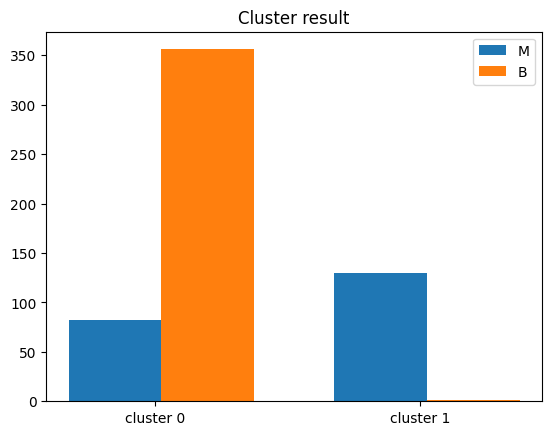

In [9]:
def draw_bar(cluster_data):
    # 构造绘图数据
    y_data = {}
    for cluster_label in cluster_data:
        for true_label in cluster_data[cluster_label]:
            y_data[true_label] = []
        break
    for cluster_label in cluster_data:
        for true_label,num in cluster_data[cluster_label].items():
            y_data[true_label] +=[num]

    # 绘图
    bar_width = 0.35
    t = 0  # 偏移量
    for key,data in y_data.items():
        plt.bar(np.arange(len(data))+t,data,label = key,width = bar_width)
        t+=bar_width

    labels = ["cluster "+str(l) for l in cluster_data]
    plt.xticks(np.arange(len(data))+bar_width-0.2,labels)
    plt.title("Cluster result")
    plt.legend()
draw_bar(cluster)

# 6. 评价指标

这里，我们选用两个外部指标，FMI和NMI。

In [10]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import fowlkes_mallows_score

In [11]:
# YOUR CODE HERE
print("NMI for selected features: ", normalized_mutual_info_score(data_y.reshape(-1), model.compute_label(data_x)))
print("FMI for selected features: ", fowlkes_mallows_score(data_y.reshape(-1), model.compute_label(data_x)))

NMI for selected features:  0.46479332792160793
FMI for selected features:  0.7915171728708068
